### Utils

In [176]:
import json
import os
import base64
import requests
def load_markdown_to_str(file_path):
	with open(file_path, 'r', encoding='utf-8') as md_file:
		markdown_content = md_file.read()
	return markdown_content

def load_txt_to_str(file_path):
    with open(file_path, 'r', encoding='utf-8') as txt_file:
        text_content = txt_file.read()
    return text_content

def load_from_json(file_path):
    try:
        with open(file_path, 'r') as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return {}
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file {file_path}")
        return {}
    
def load_latest_txt_to_str(folder_path):
    try:
        # Get all .txt files in the folder
        txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
        
        if not txt_files:
            print(f"No .txt files found in {folder_path}")
            return ""
        
        # Sort files by modification time (newest first)
        latest_file = max(txt_files, key=lambda f: os.path.getmtime(os.path.join(folder_path, f)))
        
        # Load the content of the latest file
        file_path = os.path.join(folder_path, latest_file)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
        
        return content
    except Exception as e:
        print(f"Error loading latest .txt file from {folder_path}: {str(e)}")
        return ""
    
def export_markdown(content, file_path):
    try:
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        with open(file_path, 'w', encoding='utf-8') as f:
            f.write(content)
        print(f"Successfully exported Markdown to {file_path}")
    except Exception as e:
        print(f"Error exporting Markdown: {str(e)}")

def export_json(content, file_path):
    try:
        # If content is a string, try to parse it as JSON
        if isinstance(content, str):
            content = json.loads(content)
        
        # If content is a list with one item, extract that item
        if isinstance(content, list) and len(content) == 1:
            content = content[0]
        
        # If we still have a string, it might be a nested JSON string
        if isinstance(content, str):
            content = json.loads(content)
        
        # Now we should have a proper Python dict or list
        with open(file_path, 'w') as file:
            json.dump(content, file, indent=2)
        print(f"Successfully exported JSON to {file_path}")
    except json.JSONDecodeError:
        print(f"Error: The content is not valid JSON")
    except IOError:
        print(f"Error: Unable to write to file {file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

def export_state(state, folder_path, filename):
    # Create the folder if it doesn't exist
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    id = len(files) + 1
    
    filename = filename+str(id)+".json"
    
    os.makedirs(folder_path, exist_ok=True)
    
    # Construct the full file path
    file_path = os.path.join(folder_path, filename)
    
    # Write the state dict to a JSON file
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(state, f, indent=4)
        
def render_mermaid_diagram(diagram_code: str) -> str:
    # Encode the Mermaid code
    encoded_diagram = base64.b64encode(diagram_code.encode('utf-8')).decode('utf-8')
    
    # Make a request to the Mermaid rendering service
    url = f"https://mermaid.ink/img/{encoded_diagram}"
    response = requests.get(url)
    
    if response.status_code == 200:
        # Return the URL of the rendered image
        return url
    else:
        # If rendering failed, return the original Mermaid code
        return f"```mermaid\n{diagram_code}\n```"
    
def format_mermaid(input_string):
    # Step 1: Remove the mermaid code block markers
    cleaned_string = input_string.replace('```mermaid', '').replace('```', '')
    
    # Step 2: Extract the content between <mermaid_code> tags
    start_tag = '<mermaid_code>'
    end_tag = '</mermaid_code>'
    start_index = cleaned_string.find(start_tag) + len(start_tag)
    end_index = cleaned_string.find(end_tag)
    
    if start_index != -1 and end_index != -1:
        mermaid_code = cleaned_string[start_index:end_index]
    else:
        mermaid_code = cleaned_string  # Fallback if tags are not found
    
    # Step 3: Replace escaped newlines with actual newlines
    formatted_string = mermaid_code.replace(r'\n', '\n')
    
    # Step 4: Strip any leading/trailing whitespace
    formatted_string = formatted_string.strip()

    return formatted_string

def format_items(input_string):
    # Find the start of the JSON block
    start_marker = "```json"
    end_marker = "```"
    
    start_index = input_string.find(start_marker)
    if start_index == -1:
        return ""  # Return empty string if JSON block not found
    
    # Adjust start_index to exclude the start_marker
    start_index += len(start_marker)
    
    # Find the end of the JSON block
    end_index = input_string.find(end_marker, start_index)
    if end_index == -1:
        return ""  # Return empty string if closing marker not found
    
    # Extract the JSON content between markers
    json_content = input_string[start_index:end_index]
    
    # Strip any leading/trailing whitespace
    json_content = json_content.strip()
    
    return json_content

def format_report(input_string):
    # Find the start of the JSON block
    start_marker = "```markdown"
    end_marker = "```"
    
    start_index = input_string.find(start_marker)
    if start_index == -1:
        return ""  # Return empty string if JSON block not found
    
    # Adjust start_index to exclude the start_marker
    start_index += len(start_marker)
    
    # Find the end of the JSON block
    end_index = input_string.find(end_marker, start_index)
    if end_index == -1:
        return ""  # Return empty string if closing marker not found
    
    # Extract the JSON content between markers
    json_content = input_string[start_index:end_index]
    
    # Strip any leading/trailing whitespace
    json_content = json_content.strip()
    
    return json_content

### Prompts

In [164]:
IDENTIFY_NEW_ITEMS = """
You are an AI assistant tasked with identifying potential new backlog items from a daily meeting note. Your goal is to compare the items mentioned in the meeting against the current project backlog and state to avoid duplicates and identify truly new items. Here are the steps to follow:

1. First, review the current project backlog:
<project_backlog>
{PROJECT_BACKLOG}
</project_backlog>

2. Next, familiarize yourself with the current project state:
<project_state>
{PROJECT_STATE}
</project_state>

3. Now, carefully read through the meeting note:
<meeting_note>
{MEETING_NOTE}
</meeting_note>
4. Analyze the meeting note and identify any potential new backlog items that are not already present in the current project backlog. Consider the following:
   - Tasks or action items mentioned in the meeting
   - Issues or challenges discussed that may require attention
   - New features or improvements suggested
   - Any other relevant points that could be translated into backlog items

5. Compare each potential new item against the existing backlog to ensure it's not a duplicate or already covered.

6. List ALL possible new items, even if they seem minor. Be thorough in your analysis.

7. If you identify any possible new items, list them clearly, one per line, prefixed with a hyphen (-).

8. If no new items are found after careful consideration, respond with "MOVEON".

Your output should be in the following format:
<output>
[List of potential new items, one per line, prefixed with a hyphen (-)]
</output>

OR

<output>
MOVEON
</output>

Remember, your task is to identify potential new items, not to evaluate their importance or priority. The next agent in the workflow will verify these items, so it's crucial to be comprehensive in your identification process.
"""
VERIFY_NEW_ITEMS = """
You are the "verify_new_items" agent in a workflow processing daily meeting notes. Your role is crucial in maintaining an accurate and efficient project backlog. You will receive input from the previous agent who has suggested potential new backlog items, and your task is to rigorously verify these suggestions against the current project backlog.

You will be working with the following inputs:

<previous_agent_response>
{PREVIOUS_AGENT_RESPONSE}
</previous_agent_response>

This contains the suggestions for new backlog items from the previous agent.

<project_backlog>
{PROJECT_BACKLOG}
</project_backlog>

This is the current state of the project backlog.

<employee_profiles>
{EMPLOYEE_PROFILES}
</employee_profiles>

This contains information about team members, which may be relevant for understanding the context of suggested items.

Your task is to meticulously compare each suggested item from the previous agent's response with the existing items in the project backlog. Be conservative and strict in your approach - only confirm items that are genuinely new and necessary additions to the backlog.

Verification process:
1. Carefully read and understand each suggested new item.
2. Compare each suggestion against all items in the current project backlog.
3. Consider the context provided by the employee profiles if necessary.
4. Determine if the suggested item is truly new and not already represented in the backlog in any form.
5. Assess whether the new item is necessary and adds value to the project.

After your verification, provide your output in the following format:

If you find any valid new items that are not in the current backlog:
<verified_items>
- [List each verified new item here, one per line]
</verified_items>

If none of the suggested items are valid new additions:
<verified_items>NOVALID</verified_items>

Important considerations:
- Be extremely thorough in your comparison. An item might exist in the backlog under a slightly different wording or as part of a larger task.
- Consider the scope and goals of the project when assessing the necessity of new items.
- Remember that your output will be used by subsequent agents in the workflow, so clarity and accuracy are paramount.
- Do not include any explanations or justifications outside of the specified output format.

Example output:
<verified_items>
- Implement user authentication for mobile app
- Create data backup system for cloud storage
</verified_items>

OR

<verified_items>NOVALID</verified_items>

Remember, your role is to act as a strict filter, ensuring only genuinely new and necessary items are added to the backlog. Your accurate verification is crucial for maintaining an efficient and focused project management process.
"""

FORMAT_NEW_ITEMS ="""
You are an AI assistant specializing in task assignment and management for a development team. Your role is to assign and format new items from the daily meeting, matching tasks with the most suitable team members based on their skills and current workload.

You will be working with two sets of information:

1. Verified new items from the daily meeting:
<verified_new_items>
{VERIFIED_NEW_ITEMS}
</verified_new_items>

2. Employee profiles containing skills and current workload:
<employee_profiles>
{EMPLOYEE_PROFILES}
</employee_profiles>

Your task is to:
1. Analyze each new item and the skills required to complete it.
2. Review the employee profiles to find the best match for each item.
3. Consider the current workload of employees to ensure a balanced distribution of tasks.
4. Assign each item to the most appropriate team member.
5. Format the assigned items in a JSON structure.

Before formatting the final output, wrap your analysis in <analysis> tags. For each new item:
1. List the required skills and estimated complexity.
2. Summarize each employee's relevant skills and current workload.
3. Compare task requirements with employee capabilities.
4. Explain your reasoning for the assignment, considering:
   - Required skills for the task
   - Complexity and estimated effort
   - Current workload of potential assignees
   - Any dependencies or related tasks

After your analysis, format the assigned items in the following JSON structure:

```json
[
  {{
    "id": "US001",
    "title": "Task title here",
    "description": "Detailed task description",
    "status": "Not Started",
    "priority": "High/Medium/Low",
    "estimated_effort": "X story points",
    "assigned_to": "Employee Name",
    "tags": [
      "tag1",
      "tag2",
      "tag3"
    ],
    "dependencies": []
  }},
  {{
    // Additional items...
  }}
]
```

Ensure that each item in the JSON structure includes all the fields shown in the example above. The "id" field should be a unique identifier for each task, starting with "US" followed by a three-digit number (e.g., US001, US002, etc.).

Your response should contain only the <analysis> section followed by the JSON structure. Do not include any additional text or explanations outside of these elements.

""" 
GENERAL_INFO = """
You are the general_info agent in an agentic workflow designed to process and summarize meeting information. Your role is to synthesize key information from the last meeting based on the provided meeting notes and other contextual variables. Your output will be used by other agents in the workflow, so it's essential to be precise and comprehensive in your analysis while focusing on the most important items.

Here is the information you need to analyze:

<company_data>
{COMPANY_DATA}
</company_data>

<project_general>
{PROJECT_GENERAL}
</project_general>

<project_requirements>
{PROJECT_REQUIREMENTS}
</project_requirements>

<project_state>
{PROJECT_STATE}
</project_state>

<project_backlog>
{PROJECT_BACKLOG}
</project_backlog>

<meeting_note>
{MEETING_NOTE}
</meeting_note>

Your task is to provide a clear, concise summary of the main points discussed in the meeting, focusing on decisions made and important updates or changes to the project. Prioritize information that gives a comprehensive overview of the meeting's outcomes and their impact on the project's current state, especially changes that affect all employees.

Follow these steps to complete your task:

1. Carefully read through the meeting note and all provided contextual information.
2. Identify the key topics discussed in the meeting.
3. Cross-reference the meeting topics with the project's general information, requirements, and current state.
4. Highlight any decisions made during the meeting that affect the project.
5. Note any updates or changes to the project backlog.
6. Summarize the main points, ensuring they are relevant to the project's current state and goals.
7. Review your summary to ensure it's clear, concise, and provides a comprehensive overview of the meeting's outcomes.

Before providing your final summary, wrap your analysis and thought process inside <analysis> tags. This analysis should include:
- Direct quotes of key points from the meeting note
- Relevant project data elements for each key point
- Identified decisions, updates, and changes
- Prioritization of information based on impact and relevance

This will help ensure a thorough interpretation of the data and allow you to prioritize the most important items.

Output your final summary in <general_info_summary> tags. Ensure that your summary is relevant to the project's current state and requirements, highlights any changes or updates that affect the project backlog, and identifies any new action items or decisions that impact the project timeline or goals.

Example output structure:

<analysis>
[Your detailed analysis of the meeting note and contextual information, including:
- Key topics identified with relevant quotes
- Cross-references with project information
- Important decisions and their impact
- Updates to project backlog
- Prioritization of information based on importance and relevance to all employees]
</analysis>

<general_info_summary>
[A concise paragraph summarizing the most important outcomes of the meeting, focusing on:
- Key decisions made
- Significant updates or changes to the project
- Important information relevant to all employees
- Critical impacts on project timeline or goals]
</general_info_summary>

Remember, your output will be used by other agents in the workflow, so accuracy and clarity are paramount. Focus on providing information that will be useful for updating the project state, adjusting the backlog, and informing team members of important developments.
"""
PERSONAL_SUMMARY = """
You are an AI agent in a workflow tasked with creating a personalized summary draft of the last meeting. Your role is crucial as your output will be used by subsequent agents in the workflow to generate diagrams and compile final reports. Focus solely on the content of the meeting note, tailoring the summary to the specific employee based on their profile.

First, carefully review the following meeting note:

<meeting_note>
{MEETING_NOTE}  
</meeting_note>

Next, examine the employee profiles:

<employee_profiles>
{EMPLOYEE_PROFILES}
</employee_profiles>

Now, consider the current project backlog and state:

<project_backlog>
{PROJECT_BACKLOG}
</project_backlog>

<project_state>
{PROJECT_STATE}
</project_state>

To create the personalized summary draft:

1. Identify key points from the meeting note that are directly relevant to the employee's role and responsibilities.
2. Highlight how the meeting's outcomes and decisions affect the employee's work.
3. Include any action items or tasks assigned to the employee during the meeting.
4. Mention any project updates or changes that impact the employee's current workload or future tasks.
5. Summarize any team-wide announcements or policy changes discussed in the meeting that affect the employee.

Important guidelines:
- Focus exclusively on information from the meeting note. Do not include general company information or project details unless they were explicitly discussed in the meeting.
- Tailor the language and content to the specific employee based on their profile.
- Be concise yet comprehensive, ensuring all relevant information is included.
- Do not include information from the project backlog or state unless it was directly addressed in the meeting.

Provide your personalized summary draft in the following format:

<personalized_summary_draft>
[Your summary here]
</personalized_summary_draft>

Remember, your output will be used by other agents in the workflow, so maintain accuracy and relevance in your summary.

"""

PERSONAL_DIAGRAM_PLAN = """You are the personal_diagram_plan agent in a workflow designed to process and visualize information from team meetings. Your task is to plan a mermaid diagram based on the provided meeting note, personalized summary draft, and project state. The next agent in the workflow will use your plan to generate the actual mermaid code, so be precise and comprehensive in your planning.

You will be working with the following inputs:

<meeting_note>
{MEETING_NOTE}
</meeting_note>

<personalized_summary_draft>
{PERSONALIZED_SUMMARY_DRAFT}
</personalized_summary_draft>

<project_state>
{PROJECT_STATE}
</project_state>

Your task is to plan a mermaid diagram that best represents the key information from these inputs. Follow these steps:

1. Analyze the content of the meeting note, personalized summary draft, and project state.

2. Determine the most appropriate type of mermaid diagram to visualize this information. Consider the following diagram types, but don't limit yourself to only these if another type would be more suitable:
   - Flowchart
   - User Journey
   - Gantt Chart
   - C4 Diagram
   - Mindmap
   - Sankey Diagram
   - Sequence Diagram
   - Class Diagram
   - State Diagram
   - Entity Relationship Diagram

3. Identify the key components, relationships, and information that should be included in the diagram. This may include:
   - Tasks or processes
   - Team members or roles
   - Timelines or deadlines
   - Dependencies or relationships between elements
   - Decision points or conditions
   - Data flows or information exchanges

4. List all the necessary elements and their relationships in a clear, organized manner.

5. If applicable, note any color schemes, styles, or layout preferences that would enhance the diagram's clarity and effectiveness.

Provide your output in the following format:

<diagram_plan>
Diagram Type: [Specify the chosen mermaid diagram type]

Key Components:
1. [List main elements to be included in the diagram]
2. ...

Relationships:
1. [Describe connections or dependencies between components]
2. ...

Additional Notes:
[Include any styling suggestions or special considerations]

</diagram_plan>

Remember, your plan will be used by the next agent to generate the actual mermaid code, so be as clear and specific as possible in your instructions. Focus on creating a plan that will result in a diagram that effectively visualizes the key information from the meeting and project state.
"""

PERSONAL_DIAGRAM = """
You are an AI agent responsible for generating Mermaid diagram code based on a diagram plan provided by a previous agent in a workflow. Your task is to create clear and informative Gantt charts to represent key points from a meeting.

Here is the diagram plan provided by the previous agent:

<diagram_plan>
{DIAGRAM_PLAN}
</diagram_plan>

Your goal is to generate valid, renderable Mermaid code for a Gantt chart based on this plan. Follow these instructions carefully:

1. Analyze the diagram plan, paying attention to the components, relationships, and any specific requirements mentioned.

2. Use the appropriate Mermaid syntax for Gantt charts. Here's a basic structure to follow:

```mermaid
gantt
    title [Chart Title]
    dateFormat YYYY-MM-DD
    axisFormat %d-%b

    section [Section Name]
    [Task Name] : [Task ID], [Start Date], [Duration]
    [Another Task] : [Task ID], after [Previous Task ID], [Duration]

    section [Another Section]
    [Task Name] : [Task ID], [Start Date], [Duration]

    [Milestone Name] : milestone, [Milestone ID], [Date], 0d
```

3. Incorporate all the components and relationships mentioned in the plan into your Mermaid code.

4. Ensure that the diagram accurately represents the key points from the meeting as outlined in the plan.

5. Keep the diagram clear and concise, avoiding unnecessary complexity.

6. Use appropriate styling options available in Mermaid Gantt charts to enhance readability and visual appeal.

7. Adhere to these important guidelines to avoid common mistakes:
   - Use only standard Mermaid Gantt chart syntax.
   - Don't include custom commands like verticalLine or verticalLineFill.
   - Don't use click events or custom styling (classDef, class).
   - Use the correct syntax for dependencies: "task_name : after previous_task".
   - Stick to a consistent date format (preferably YYYY-MM-DD).
   - Don't include a separate "Legend" section; consider adding this information in the chart title if necessary.
   - Use the `crit` keyword correctly within task definitions for critical path items.
   - Avoid using unsupported features like weekend styling.

Before generating the final code, wrap your analysis inside <thinking> tags. In this analysis:
1. List all components, relationships, and specific requirements from the plan.
2. Outline the structure of the Gantt chart, including sections, tasks, and milestones.
3. Identify any potential challenges or ambiguities in the plan and how you'll address them.
4. Plan out how you'll incorporate all necessary elements into the Mermaid syntax.

Then, provide your final Mermaid code output within <mermaid_code> tags. Do not include any other text or explanations outside of these tags.

Remember that your output will be used to render a visual Gantt chart, so accuracy and adherence to Mermaid syntax are crucial.
"""

COMPILE_REPORT = """

You are the final agent in a workflow system responsible for creating personalized meeting reports for employees. Your task is to compile a comprehensive report based on a recent meeting, tailored specifically for one employee. You will integrate various inputs to create an informative and actionable report.

Please review the following input materials:

1. Project State - Project current state, this if for you to understand the state of the project:
<project_state>
{PROJECT_STATE}
</project_state>

2. Employee Profile - Information about the employee whose report you need to compile.:
<employee_profile>
{EMPLOYEE_PROFILE}
</employee_profile>

3. Personalized Summary Draft - Personalized information based in the employee:
<personalized_summary_draft>
{PERSONALIZED_SUMMARY_DRAFT}
</personalized_summary_draft>

4. General Information - Key information that effect all the team members:
<general_information>
{GENERAL_INFORMATION}
</general_information>

5. Diagram - This can be an URL if it is the make ![Diagram](diagram URL) tag where you include the following link. If it is not you can skip this:
<diagram>
{DIAGRAM_CODE}
</diagram>

Your goal is to create a report that is directly relevant and actionable for the specific employee, highlighting key takeaways and next steps most pertinent to their role and responsibilities.

Before composing the final report, organize your thoughts inside <report_preparation> tags. Consider the following steps:

1. Analyze the employee profile.

2. Review the personalized summary draft.

3. Assess the project state.

4. Review the general information.

5. Identify conflicts and inconsistencies:
   - Compare the information from different sources and note any potential conflicts or inconsistencies.

7. Prioritization:
   - Rank the information from all sources based on its value and actionability for the employee.
   - Plan how to present this information concisely and professionally.

After your preparation, compile the report using the following structure in markdown format:

1. Briefly about meeting
2. Key meeting highlights (bullet points)
3. Show diagram
4. Action items or next steps specific to the employee
5. General information affecting the whole team
6. Brief conclusion

Important guidelines:
- Use a professional tone and language appropriate for business communication.
- Focus on information directly applicable to the employee's role and responsibilities.
- Clearly highlight any action items or decisions that impact the employee.
- Ensure the report is comprehensive without unnecessary verbosity.

Present your final output in markdown format, starting with a code block for markdown.
The diagram needs to be included with ![Diagram](diagram URL).
"""

### State

In [139]:
from typing import TypedDict, Dict

class DailyMeetingState(TypedDict):
    company_data: str	
    project_general: str	
    project_requirements: str
    employee_profiles: str	
    employee_profiles_json: Dict[str, str]

    state: str
    backlog: str
    note: str

    possible_new_items : str
    new_items : str

    items_json : str

    general_info : str
    personal_summary_draft: Dict[str, str] 
    diagram_plan : Dict[str, str]
    reports: Dict[str, str]  # Key: employee name, Value: report content
    diagrams: Dict[str, str]  # Key: employee name, Value: Mermaid diagram code


### Workflow and graph

In [178]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from dotenv import load_dotenv

class DailyMeetingWorkflow:
    def __init__(self,model):
        self.model = model
        self.state = DailyMeetingState()
        graph = StateGraph(DailyMeetingState)
        graph.add_node("identify_new_items", self.identify_new_items)
        graph.add_node("verify_new_items",self.verify_new_items)
        graph.add_node("format_new_items", self.format_new_items)
        graph.add_node("open_issue",self.open_issue)
        graph.add_node("collect_general_info",self.general_info)
        graph.add_node("personal_summary",self.personal_summary)
        graph.add_node("personal_diagram_plan",self.personal_diagram_plan)
        graph.add_node("personal_diagram",self.personal_diagram)
        graph.add_node("render_diagram",self.render_diagram)
        graph.add_node("compile_report",self.compile_report)
        graph.add_node("export_reports",self.export_reports)

        graph.add_conditional_edges(
            "identify_new_items",
            self.is_new_item,
            {"yes": "verify_new_items", "no" : "collect_general_info"}
        )
        graph.add_conditional_edges(
            "verify_new_items",
            self.is_valid_item,
            {"yes" : "format_new_items", "no": "collect_general_info"}
        )
        graph.add_edge("format_new_items", "open_issue")
        graph.add_edge("open_issue","collect_general_info")
        graph.add_edge("collect_general_info","personal_summary")
        graph.add_edge("personal_summary","personal_diagram_plan")
        graph.add_edge("personal_diagram_plan","personal_diagram")
        graph.add_edge("personal_diagram","render_diagram")
        graph.add_edge("render_diagram", "compile_report")
        graph.add_edge("compile_report","export_reports")
        graph.add_edge("export_reports", END)
        
        graph.set_entry_point("identify_new_items")

        self.graph = graph.compile()

    def is_new_item(self, state : DailyMeetingState):
        if "MOVEON" in self.state["possible_new_items"]:
            return "no"
        else:
            return "yes"
    
    def is_valid_item(self, state : DailyMeetingState):
        if "NOVALID" in self.state["new_items"]:
            return "no"
        else: 
            return "yes"

    
    def identify_new_items(self, state : DailyMeetingState):
        formatted_prompt = IDENTIFY_NEW_ITEMS.format(
            PROJECT_BACKLOG  = self.state.get("backlog"),
            PROJECT_STATE = self.state.get("state"),
            MEETING_NOTE = self.state.get("note")
        )
        messages = [
            HumanMessage(content=formatted_prompt)
        ]
        response = self.model.invoke(messages)
        self.state["possible_new_items"] = response.content
        return self.state
    
    def verify_new_items(self, state : DailyMeetingState):
        formatted_prompt = VERIFY_NEW_ITEMS.format(
            PREVIOUS_AGENT_RESPONSE = self.state.get("possible_new_items"),
            PROJECT_BACKLOG = self.state.get("backlog"),
            EMPLOYEE_PROFILES = self.state.get("employee_profiles"),
        )
        messages = [
            HumanMessage(content=formatted_prompt)
        ]
        response = self.model.invoke(messages)
        self.state["new_items"] = response.content
        return self.state
    
    def format_new_items(self, state : DailyMeetingState):
        formatted_prompt = FORMAT_NEW_ITEMS.format(
            VERIFIED_NEW_ITEMS = self.state.get("new_items"),
            EMPLOYEE_PROFILES = self.state.get("employee_profiles"),
        )
        messages = [
            HumanMessage(content=formatted_prompt),
            AIMessage(content="<analysis>")
        ]
        response = self.model.invoke(messages)
        self.state["items_json"] = response.content
        return self.state
    
    def open_issue(self, state: DailyMeetingState):
        load_dotenv()  # Load environment variables

        # GitHub API endpoint
        api_url = "https://api.github.com/repos/VarjuAkos/HealthTrack-Pro/issues"

        # Get GitHub token from environment variable
        token = os.getenv("GITHUB_TOKEN")

        backlog_items = json.loads(format_items(self.state["items_json"]))

        for backlog_item in backlog_items:
            # Create the issue body
            issue_body = f"""
            **Description:** {backlog_item['description']}

            **Status:** {backlog_item['status']}
            **Priority:** {backlog_item['priority']}
            **Estimated Effort:** {backlog_item['estimated_effort']}
            **Assigned To:** {backlog_item['assigned_to']}

            **Tags:** {', '.join(backlog_item['tags'])}

            **ID:** {backlog_item['id']}
            """

            # Prepare the data for the API request
            data = {
                "title": backlog_item['title'],
                "body": issue_body,
                "labels": backlog_item['tags']
            }

            # Set up the headers for authentication
            headers = {
                "Authorization": f"token {token}",
                "Accept": "application/vnd.github.v3+json"
            }

            # Send the POST request to create the issue
            response = requests.post(api_url, headers=headers, data=json.dumps(data))

            # Check the response
            if response.status_code == 201:
                print(f"Issue '{backlog_item['title']}' created successfully!")
                print(f"Issue URL: {response.json()['html_url']}")
            else:
                print(f"Failed to create issue '{backlog_item['title']}'. Status code: {response.status_code}")
                print(f"Response: {response.text}")

        return state
    
    def general_info(self, state : DailyMeetingState):
        formatted_prompt = GENERAL_INFO.format(
            COMPANY_DATA = self.state.get("company_data"),
            PROJECT_GENERAL = self.state.get("project_general"),
            PROJECT_REQUIREMENTS = self.state.get("project_requirements"),
            PROJECT_STATE = self.state.get("state"),
            PROJECT_BACKLOG = self.state.get("backlog"),
            MEETING_NOTE = self.state.get("note"),
        )
        messages = [
            HumanMessage(content=formatted_prompt)
        ]
        response = self.model.invoke(messages)
        self.state["general_info"] = response.content
        return self.state
    
    def personal_summary(self, state : DailyMeetingState):
        for employee, profile in self.state["employee_profiles_json"].items():
            formatted_prompt = PERSONAL_SUMMARY.format(
                MEETING_NOTE = self.state.get("note"),
                EMPLOYEE_PROFILES = str(employee) + ": " + str(profile),
                PROJECT_BACKLOG = self.state.get("backlog"),
                PROJECT_STATE = self.state.get("state"),
            )
            print("!: ",str(employee) + ": " + str(profile))
            messages = [
                HumanMessage(content=formatted_prompt)
            ]
            response = self.model.invoke(messages)
            self.state["personal_summary_draft"][employee] = response.content
        return self.state
    
    def personal_diagram_plan(self, state : DailyMeetingState):
        for employee, profile in self.state["employee_profiles_json"].items():
            formatted_prompt = PERSONAL_DIAGRAM_PLAN.format(
                MEETING_NOTE = self.state.get("note"),
                PERSONALIZED_SUMMARY_DRAFT = self.state.get("personal_summary_draft")[employee],
                PROJECT_BACKLOG = self.state.get("backlog"),
                PROJECT_STATE = self.state.get("state"),
            )
            messages = [
                HumanMessage(content=formatted_prompt)
            ]
            response = self.model.invoke(messages)
            self.state["diagram_plan"][employee] = response.content
        return self.state
    
    def personal_diagram(self, state: DailyMeetingState):
        for employee, profile in self.state["employee_profiles_json"].items():
            formatted_prompt = PERSONAL_DIAGRAM.format(
                DIAGRAM_PLAN = self.state.get("diagram_plan")[employee]
            )
            messages = [
                HumanMessage(content=formatted_prompt)
            ]
            response = self.model.invoke(messages)
            self.state["diagrams"][employee] = response.content
        return self.state

    
    def render_diagram(self, state : DailyMeetingState):
        for employee in self.state["employee_profiles_json"].keys():
            self.state["diagrams"][employee] = render_mermaid_diagram(format_mermaid(self.state["diagrams"][employee]))
        return self.state
    
    def compile_report(self, state : DailyMeetingState):
        for employee, profile in self.state["employee_profiles_json"].items():
            formatted_prompt = COMPILE_REPORT.format(
                PROJECT_STATE = self.state.get("state"),
                EMPLOYEE_PROFILE = str(employee) + ": " + str(profile),
                PERSONALIZED_SUMMARY_DRAFT = self.state.get("personal_summary_draft")[employee],
                GENERAL_INFORMATION = self.state.get("general_info"),
                DIAGRAM_CODE = self.state.get("diagrams")[employee],
            )
            messages = [
                HumanMessage(content=formatted_prompt)
            ]
            response = self.model.invoke(messages)
            self.state["reports"][employee] = response.content

        return self.state
    
    def export_reports(self, state : DailyMeetingState):
        for employee, report in self.state["reports"].items():
            export_markdown(format_report(report), os.path.join("../data_/project2.0", "reports", f"{employee}_report_daily_report.md"))
        return 
    
    def init_state(self, state : DailyMeetingState):
        self.state = DailyMeetingState(
            company_data= load_markdown_to_str("../data_/project2.0/company-general.md"),
            project_general= load_markdown_to_str("../data_/project2.0/project-general.md"),
            project_requirements= load_markdown_to_str("../data_/project2.0/project-requirements.md"),
            employee_profiles= load_markdown_to_str("../data_/project2.0/employee-profiles.md"),
            employee_profiles_json = load_from_json("../data_/project2.0/employee-profiles.json"),
            
            state=load_markdown_to_str("../data_/project2.0/project-state.md"),
            backlog=load_from_json("../data_/project2.0/project-backlog.json"),
            note=load_markdown_to_str("../data_/project2.0/memo/memo.md"),

            possible_new_items= "",
            new_items = "",
            items_json = "",
            personal_summary_draft = {},
            personal_tasks = {},
            reports = {},
            diagrams = {},
            diagram_plan = {}
        )
        return self.state
    
    
    def run(self):
        self.init_state(self.state)
        self.graph.invoke(self.state)
        export_state(state=self.state, folder_path="../data_/project2.0/states/daily_meeting",filename="daily_meeting")
        return self.state


### Testing

Error: Invalid JSON format in file ../data_/project2.0/project-backlog.json


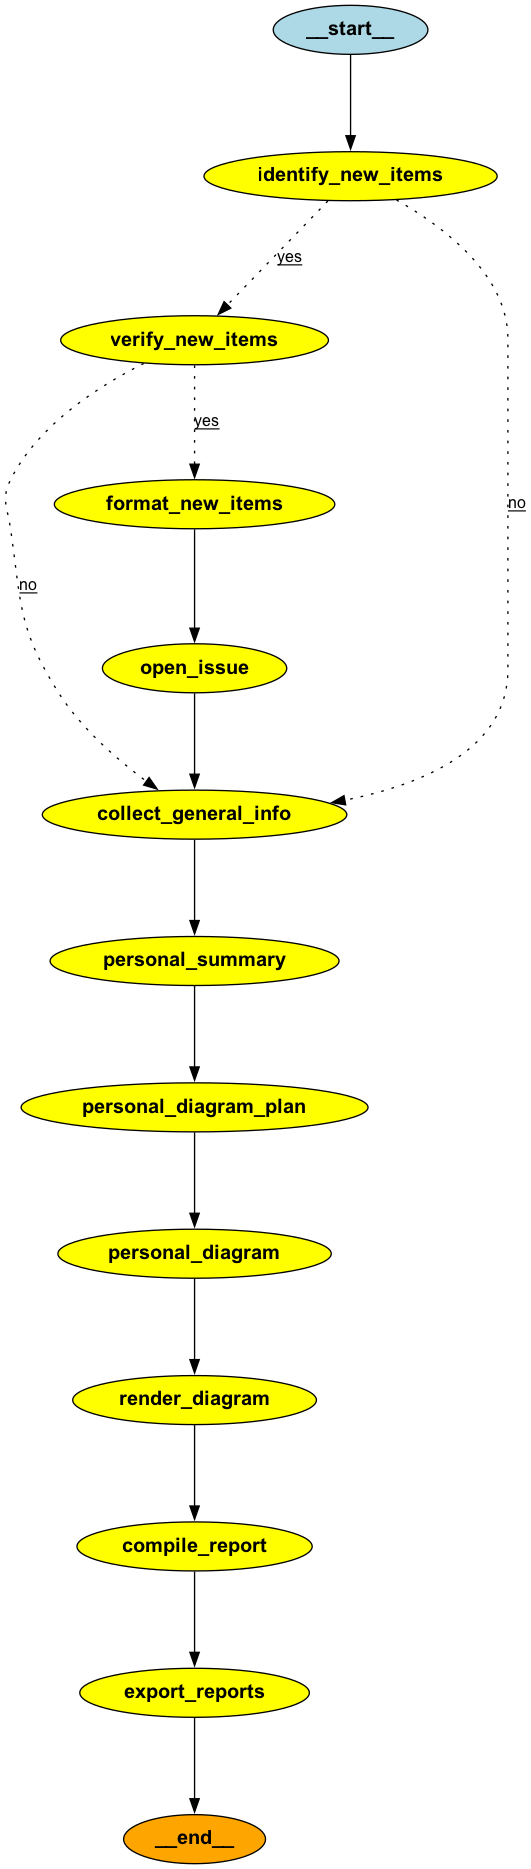

In [180]:
from langchain_anthropic import ChatAnthropic
from  dotenv import load_dotenv
from IPython.display import Image
import os

load_dotenv()
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
model = ChatAnthropic(model="claude-3-5-sonnet-20240620", anthropic_api_key=anthropic_api_key, max_tokens= 4096)

daily_agent = DailyMeetingWorkflow(model=model)
daily_agent.init_state(daily_agent.state)
Image(daily_agent.graph.get_graph().draw_png())

In [143]:
daily_agent.init_state(daily_agent.state)
daily_agent.identify_new_items(daily_agent.state)
print(daily_agent.state["possible_new_items"])

Error: Invalid JSON format in file ../data_/project2.0/project-backlog.json
After carefully analyzing the meeting note and comparing it with the current project backlog and state, I have identified the following potential new items:

<output>
- Set up Redux for state management in the frontend
- Design and implement initial database schema for user information, considering future scalability for health data storage
- Implement daily check-ins between design and development teams to ensure alignment
- Set up early browser testing to mitigate cross-browser compatibility issues
- Create a basic goal-setting feature as part of the MVP
- Schedule and conduct a session on data security and GDPR compliance (led by Alex)
- Set up testing environments for frontend and backend
- Create initial design system in Figma, focusing on components needed for authentication and profile management
- Establish and document team coding standards
- Set up multiple browser testing (Chrome, Firefox, Safari) as

In [145]:
daily_agent.verify_new_items(daily_agent.state)
print(daily_agent.state["new_items"])

<verified_items>
- Set up Redux for state management in the frontend
- Design and implement initial database schema for user information, considering future scalability for health data storage
- Implement daily check-ins between design and development teams to ensure alignment
- Set up early browser testing to mitigate cross-browser compatibility issues
- Create a basic goal-setting feature as part of the MVP
- Schedule and conduct a session on data security and GDPR compliance (led by Alex)
- Set up testing environments for frontend and backend
- Create initial design system in Figma, focusing on components needed for authentication and profile management
- Establish and document team coding standards
- Create and update project documentation
- Set up a staging environment for feature deployment
- Implement authentication token handling in the frontend
</verified_items>


In [146]:
daily_agent.format_new_items(daily_agent.state)
print(daily_agent.state["items_json"])


1. Set up Redux for state management in the frontend
   Required skills: React.js, Redux, frontend development
   Estimated complexity: Medium

   Emily Watson is the most suitable candidate due to her expertise in React.js and experience with state management libraries like Redux. Her current workload as a frontend developer allows for taking on this task.

2. Design and implement initial database schema for user information
   Required skills: Database design, PostgreSQL, backend development
   Estimated complexity: High

   Michael Kim is the best fit for this task due to his expertise in database management and experience with PostgreSQL. As a backend developer, he has the necessary skills to design scalable database schemas.

3. Implement daily check-ins between design and development teams
   Required skills: Project management, communication
   Estimated complexity: Low

   Sarah Chen, as the Project Manager and Scrum Master, is the ideal person to implement this process. Her r

In [147]:
daily_agent.open_issue(daily_agent.state)

Issue 'Set up Redux for state management in the frontend' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/34
Issue 'Design and implement initial database schema for user information' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/35
Issue 'Implement daily check-ins between design and development teams' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/36
Issue 'Set up early browser testing' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/37
Issue 'Create a basic goal-setting feature for MVP' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/38
Issue 'Conduct session on data security and GDPR compliance' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issues/39
Issue 'Set up testing environments' created successfully!
Issue URL: https://github.com/VarjuAkos/HealthTrack-Pro/issue

{'company_data': '# TechNova Solutions\n\n## Company Overview\nTechNova Solutions is a small, dynamic IT company specializing in web application development. With a team of 6 skilled professionals, they focus on creating innovative, user-friendly web solutions for small to medium-sized businesses.\n\n## Current Project: HealthTrack Pro\nTechNova is developing HealthTrack Pro, a comprehensive web application for personal health management. This application allows users to track their daily activities, nutrition, and health metrics, and provides insights and recommendations for a healthier lifestyle.\n\n## Team Structure\n1. ** Sarah Chen - Project Manager / Scrum Master**\n   - Oversees project progress, manages timelines, and facilitates communication\n   - Has a background in both frontend and backend development\n\n2. ** Alex Rodriguez - Senior Full-Stack Developer**\n   - Leads technical decisions and architecture design\n   - Proficient in both frontend and backend technologies\n\n

In [148]:
daily_agent.general_info(daily_agent.state)
print(daily_agent.state["general_info"])

<analysis>
Key topics identified from the meeting note:

1. Sprint Planning and Goal Setting
Quote: "Sprint Goal: Implement secure user authentication and basic profile management to enable user onboarding for HealthTrack Pro."
Relevance: This aligns with the project's initial phase and sets a clear focus for the first sprint.

2. MVP Features Definition
Quote: "The team discussed and agreed on the following core MVP features: 1. User authentication, 2. Basic profile management, 3. Activity tracking (steps and exercise), 4. Basic nutrition logging, 5. Simple health metrics dashboard, 6. Basic goal-setting (added during the meeting)"
Relevance: This clarifies the immediate project scope and priorities, with a notable addition of basic goal-setting to the MVP features.

3. Sprint Backlog and Story Points
Quote: "Total Story Points for Sprint: 29 points + 3 buffer points = 32 points"
Relevance: This establishes the team's initial velocity and workload for the sprint.

4. Technical Stack D

In [149]:
daily_agent.personal_summary(daily_agent.state)
for item in daily_agent.state["personal_summary_draft"]:
    print(daily_agent.state["personal_summary_draft"][item],"\n \n------ \n")

!:  Sarah Chen: {'role': 'Project Manager / Scrum Master', 'responsibilities': ['Oversee project progress and timelines', 'Facilitate communication between team members and stakeholders', 'Conduct sprint planning, daily stand-ups, and retrospectives', 'Manage project risks and resources'], 'skills': ['Certified Scrum Master', 'Proficient in Agile methodologies', 'Experienced with project management tools (Jira, Trello)', 'Basic understanding of both frontend (React) and backend (Node.js) development', 'Excellent communication and leadership skills']}
!:  Alex Rodriguez: {'role': 'Senior Full-Stack Developer', 'responsibilities': ['Lead technical decisions and architecture design', 'Mentor junior developers', 'Implement complex features across the stack', 'Code review and quality assurance'], 'skills': ['Expert in React.js, Node.js, and Express.js', 'Proficient in database design and management (PostgreSQL)', 'Experienced with cloud services (AWS)', 'Strong problem-solving and system de

In [150]:
daily_agent.personal_diagram_plan(daily_agent.state)
for item in daily_agent.state["diagram_plan"]:
    print(daily_agent.state["diagram_plan"][item],"\n \n------ \n")

<diagram_plan>
Diagram Type: Gantt Chart

Key Components:
1. Sprint Timeline (June 24 - July 7, 2024)
2. User Stories:
   a. User Registration
   b. User Login
   c. Profile Management
3. Tasks for each User Story
4. Team Members: Sarah, Alex, Emily, Michael, Olivia, Liam
5. Milestones:
   a. Sprint Start
   b. Data Security Session
   c. Daily Stand-ups
   d. Sprint Review and Retrospective

Relationships:
1. Tasks are grouped under their respective User Stories
2. Each task is assigned to a team member
3. Tasks have durations based on their story points (1 point = 1 day)
4. Some tasks have dependencies (e.g., backend tasks before frontend tasks)
5. Milestones are placed at specific dates within the sprint

Additional Notes:
1. Use color coding for different team members or roles:
   - Project Management (Sarah): Blue
   - Frontend (Emily): Green
   - Backend (Michael): Red
   - QA/DevOps (Olivia): Purple
   - UI/UX (Liam): Orange
   - Full-Stack (Alex): Yellow
2. Add a section for th

In [151]:
daily_agent.personal_diagram(daily_agent.state)
for item in daily_agent.state["diagrams"]:
    print(daily_agent.state["diagrams"][item],"\n \n------ \n")

<thinking>
Components, relationships, and requirements:
1. Sprint Timeline: June 24 - July 7, 2024
2. User Stories: User Registration, User Login, Profile Management
3. Tasks for each User Story
4. Team Members: Sarah, Alex, Emily, Michael, Olivia, Liam
5. Milestones: Sprint Start, Data Security Session, Daily Stand-ups, Sprint Review and Retrospective
6. Color coding for team members/roles
7. Buffer time at the end of the sprint
8. Daily stand-ups as recurring events
9. Sprint goal at the top of the chart
10. Dependencies between tasks
11. Legend for color coding and symbols (will be addressed in the title)

Structure outline:
1. Title: Include sprint goal and legend information
2. Date format and axis format
3. Sections for each User Story
4. Tasks under each section with assigned team members and durations
5. Milestones at specific dates
6. Daily stand-ups as a separate section
7. Buffer time section at the end

Challenges and solutions:
1. Limited color options in Mermaid: Use avai

In [153]:
daily_agent.render_diagram(daily_agent.state)
for item in daily_agent.state["diagrams"]:
    print(daily_agent.state["diagrams"][item],"\n \n------ \n")

```mermaid
gantt
    title Sprint Goal: Implement User Authentication System | Legend: Blue (PM), Green (Frontend), Red (Backend), Purple (QA/DevOps), Orange (UI/UX), Yellow (Full-Stack)
    dateFormat YYYY-MM-DD
    axisFormat %d-%b

    section Sprint Start
    Sprint Start : milestone, m1, 2024-06-24, 0d

    section User Registration
    Backend Setup : red, task1, 2024-06-24, 2d
    Frontend Form : green, task2, after task1, 2d
    API Integration : yellow, task3, after task2, 1d
    UI Design : orange, task4, 2024-06-24, 2d
    Testing : purple, task5, after task3, 1d

    section User Login
    Backend Auth : red, task6, after task1, 2d
    Frontend Login : green, task7, after task6, 2d
    API Integration : yellow, task8, after task7, 1d
    UI Design : orange, task9, after task4, 2d
    Testing : purple, task10, after task8, 1d

    section Profile Management
    Backend API : red, task11, after task6, 2d
    Frontend Profile : green, task12, after task11, 2d
    Data Binding 

In [154]:
daily_agent.state["diagrams"]

{'Sarah Chen': '```mermaid\ngantt\n    title Sprint Goal: Implement User Authentication System | Legend: Blue (PM), Green (Frontend), Red (Backend), Purple (QA/DevOps), Orange (UI/UX), Yellow (Full-Stack)\n    dateFormat YYYY-MM-DD\n    axisFormat %d-%b\n\n    section Sprint Start\n    Sprint Start : milestone, m1, 2024-06-24, 0d\n\n    section User Registration\n    Backend Setup : red, task1, 2024-06-24, 2d\n    Frontend Form : green, task2, after task1, 2d\n    API Integration : yellow, task3, after task2, 1d\n    UI Design : orange, task4, 2024-06-24, 2d\n    Testing : purple, task5, after task3, 1d\n\n    section User Login\n    Backend Auth : red, task6, after task1, 2d\n    Frontend Login : green, task7, after task6, 2d\n    API Integration : yellow, task8, after task7, 1d\n    UI Design : orange, task9, after task4, 2d\n    Testing : purple, task10, after task8, 1d\n\n    section Profile Management\n    Backend API : red, task11, after task6, 2d\n    Frontend Profile : green, t

In [173]:
daily_agent.compile_report(daily_agent.state)

{'company_data': '# TechNova Solutions\n\n## Company Overview\nTechNova Solutions is a small, dynamic IT company specializing in web application development. With a team of 6 skilled professionals, they focus on creating innovative, user-friendly web solutions for small to medium-sized businesses.\n\n## Current Project: HealthTrack Pro\nTechNova is developing HealthTrack Pro, a comprehensive web application for personal health management. This application allows users to track their daily activities, nutrition, and health metrics, and provides insights and recommendations for a healthier lifestyle.\n\n## Team Structure\n1. ** Sarah Chen - Project Manager / Scrum Master**\n   - Oversees project progress, manages timelines, and facilitates communication\n   - Has a background in both frontend and backend development\n\n2. ** Alex Rodriguez - Senior Full-Stack Developer**\n   - Leads technical decisions and architecture design\n   - Proficient in both frontend and backend technologies\n\n

In [174]:
for item in daily_agent.state["reports"]:
    print(daily_agent.state["reports"][item],"\n \n------ \n")

<report_preparation>
1. Employee Profile Analysis:
   - Sarah Chen is the Project Manager and Scrum Master
   - Key responsibilities: project oversight, team communication, sprint management, risk management
   - Skills: Scrum Master certified, Agile methodologies, project management tools, basic tech understanding

2. Personalized Summary Review:
   - Aligns well with Sarah's role and responsibilities
   - Highlights key aspects of sprint planning, risk management, and team coordination
   - Provides specific action items for Sarah

3. Project State Assessment:
   - Sprint 1 details (June 24 - July 7, 2024)
   - Focus on user authentication and profile management
   - Team responsibilities and technical stack defined
   - Risks and mitigation strategies identified

4. General Information Review:
   - Confirms sprint goals, MVP features, and technical decisions
   - Emphasizes the addition of basic goal-setting to MVP features
   - Highlights risk identification and mitigation strategi

In [175]:
tmp = daily_agent.state

In [179]:
tmp

{'company_data': '# TechNova Solutions\n\n## Company Overview\nTechNova Solutions is a small, dynamic IT company specializing in web application development. With a team of 6 skilled professionals, they focus on creating innovative, user-friendly web solutions for small to medium-sized businesses.\n\n## Current Project: HealthTrack Pro\nTechNova is developing HealthTrack Pro, a comprehensive web application for personal health management. This application allows users to track their daily activities, nutrition, and health metrics, and provides insights and recommendations for a healthier lifestyle.\n\n## Team Structure\n1. ** Sarah Chen - Project Manager / Scrum Master**\n   - Oversees project progress, manages timelines, and facilitates communication\n   - Has a background in both frontend and backend development\n\n2. ** Alex Rodriguez - Senior Full-Stack Developer**\n   - Leads technical decisions and architecture design\n   - Proficient in both frontend and backend technologies\n\n

In [181]:
daily_agent.state = tmp
daily_agent.export_reports(daily_agent.state)

Successfully exported Markdown to ../data_/project2.0/reports/Sarah Chen_report_daily_report.md
Successfully exported Markdown to ../data_/project2.0/reports/Alex Rodriguez_report_daily_report.md
Successfully exported Markdown to ../data_/project2.0/reports/Emily Watson_report_daily_report.md
Successfully exported Markdown to ../data_/project2.0/reports/Michael Kim_report_daily_report.md
Successfully exported Markdown to ../data_/project2.0/reports/Olivia Martinez_report_daily_report.md
Successfully exported Markdown to ../data_/project2.0/reports/Liam Foster_report_daily_report.md


In [183]:
daily_agent.state
export_state(state=daily_agent.state, folder_path="../data_/project2.0/states/daily_meeting",filename="daily_meeting")
